In [2]:
from astropy.table import Table
import numpy as np
import argparse
from jax import jit
import itertools
from scipy import interpolate

from Payne.jax.genmod import GenMod
from runUTPcomp import getdata

import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

import os
import csv
%matplotlib inline

In [3]:
specNN = './models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
photNN = './models/photNN/'
NNtype = 'LinNet'
mistNN = './models/mistNN/mistyNN_2.3_v256_v0.h5'
SBlib  = './models/specNN/c3k_v1.3.sed_r500.h5'

def planck(wav, T):
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    wave_i = wav*(1E-10)
    a = 2.0*h*c**2
    b = h*c/(wave_i*k*T)
    intensity = a/ ( (wave_i**5) * (np.exp(b) - 1.0) )
    return intensity

from scipy import constants
speedoflight = constants.c / 1000.0

# useful constants
# speedoflight = 2.997924e+10
speedoflight_kms = 2.997924e+5
speedoflight_nms = 2.997924e+17
lsun = 3.846e33
pc = 3.085677581467192e18  # in cm
jansky_cgs = 1e-23
# value to go from L_sun to erg/s/cm^2 at 10pc
log_rsun_cgs = np.log10(6.955) + 10.0
log_lsun_cgs = np.log10(lsun)
log4pi = np.log10(4 * np.pi)

rng = np.random.default_rng()

In [4]:
# make spectral prediction
data_p = getdata(spec='synth_spec_RV25.csv', phot='synth_phot_g3.57.csv')
data_s = getdata(spec='synth_spec_RV44.csv', phot='synth_phot_g4.16.csv')
data_p

{'spec': {'obs_wave': <Column name='wave' dtype='float64' length=14128>
    5102.44019769569
   5102.457205829683
   5102.474214020369
  5102.4912222677485
   5102.508230571823
   5102.525238932592
   5102.542247350055
   5102.559255824213
   5102.576264355066
   5102.593272942613
   5102.610281586857
   5102.627290287795
                 ...
  5348.2825125455975
   5348.300340153973
   5348.318167821773
   5348.335995548999
   5348.353823335651
   5348.371651181729
   5348.389479087234
   5348.407307052164
   5348.425135076521
   5348.442963160304
   5348.460791303515,
  'obs_flux': <Column name='flux' dtype='float64' length=14128>
  0.9159410578548352
  0.9078582108116194
  0.9018558430388565
  0.8984744733366179
  0.8982361347145041
  0.9014401430922057
   0.907949565085793
  0.9171966974602913
  0.9276211590300824
  0.9376419239229967
  0.9458682439789926
  0.9512888086246055
                 ...
   1.124413550398928
   1.122291623651664
   1.118776728298133
  1.1134851173819087
  

In [5]:
logr_p = 0.22
logr_s = 0.15

Teff_p = 5564.35
Teff_s = 5300

radius_p = 10.0**logr_p
radius_s = 10.0**logr_s

# todo: is this the proper way to get the ratio? I'm not sure it makes sense
flux2_interp = np.interp(data_p['spec']['obs_wave'], data_s['spec']['obs_wave'], data_s['spec']['obs_flux'])

R = (
    (planck(data_p['spec']['obs_wave'],Teff_p) * radius_p**2.0) / 
    (planck(data_p['spec']['obs_wave'],Teff_s) * radius_s**2.0)
     )


speccomp = (data_p['spec']['obs_flux'] + R * flux2_interp) / (1.0 + R)
speccomp[:5]

0.8895936067189846
0.8866864959942087
0.8845276585213462
0.8833115014738564
0.8832257837298932


In [6]:
# sanity checks
print(np.where(R<0))
print(np.where(R<1))

(array([], dtype=int64),)
(array([], dtype=int64),)


In [7]:
# todo: do i have to add noise now or later?
# add noise, setting seed for reproducibility
np.random.seed(0)

# mu and sigma come from hectochelle data:
# file: data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5
# target id: 2076392838230907392
mu, sigma = 0.055402016862253524, 0.004453214396949145
noise = np.random.normal(mu, sigma, len(speccomp))
speccomp = speccomp + noise
print(speccomp[:5])

       flux       
------------------
0.9528513268852732
0.9438704986978061
0.9442882054652604
0.9486926961928193
  0.94694443672102


(5200.0, 5215.0)

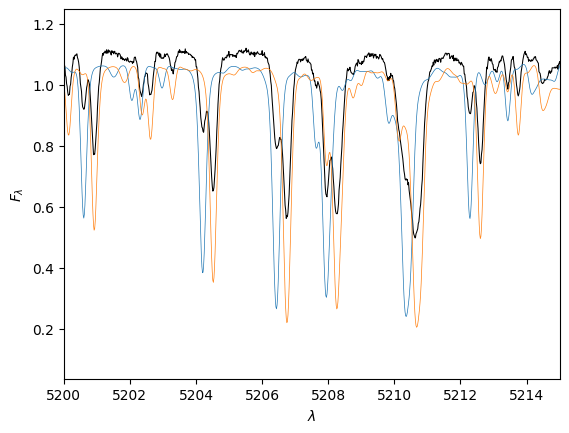

In [8]:
fig, ax = plt.subplots()
ax.plot(data_p['spec']['obs_wave'], speccomp, ls='-',lw=0.75,c='k',zorder=0)
# ax.plot(data_p['spec']['obs_wave'], data_p['spec']['obs_flux']+flux2_interp, ls='-',lw=0.5,c='C3',zorder=0)
ax.plot(data_p['spec']['obs_wave'], data_p['spec']['obs_flux'], ls='-',lw=0.5,c='C0',zorder=1)
ax.plot(data_p['spec']['obs_wave'], flux2_interp, ls='-',lw=0.5,c='C1',zorder=1)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$F_\lambda$')

ax.set_xlim(5200,5215)

In [9]:
# make phot prediction
for i in data_p['phot'].keys():
    print(i)

phot_p = [data_p['phot'][xx][0] for xx in data_p['phot'].keys()]
phot_s = [data_s['phot'][xx][0] for xx in data_s['phot'].keys()]
print(phot_p, len(phot_p))

photcomp = (
    [-2.5 * np.log10( 10.0**(-0.4 * m_p) + 10.0**(-0.4 * m_s) )
     for m_p,m_s in zip(phot_p,phot_s)
     ] 
)

WAVE_d = {'GaiaDR3_G': 6217.59,
        'GaiaDR3_BP': 5109.71,
        'GaiaDR3_RP': 7769.02,
        '2MASS_J': 12350.0,
        '2MASS_H': 16620.0,
        '2MASS_Ks': 21590.0,
        'PS_g': 4775.6,
        'PS_r': 6129.5,
        'PS_i': 7484.6,
        'PS_z': 8657.8
       }

WAVE = np.array([ii for ii in WAVE_d.values()])
# (len(WAVE_d.values()),
# len(photcomp))

GaiaDR3_G
GaiaDR3_BP
GaiaDR3_RP
2MASS_J
2MASS_H
2MASS_Ks
PS_g
PS_r
PS_i
PS_z
[-10.04302083875672, -9.58014006768941, -10.143335055396763, -7.1985080225608, -8.294617671194915, -7.921027937373541, -8.465367317471964, -7.360945117429496, -8.666313202274349, -7.930015298263717] 10


In [10]:
# make some errors (taken from the known SB2 Gaia DR3 2076392838230907392)
emags = [0.05000091916311386,
         0.05004763662644478,
         0.050012894094444295,
         0.07733692547677395,
         0.08683893326204858,
         0.10121264701645077,
         0.020829461749839007,
         0.02065512096136038,
         0.020870045165005097,
         0.020915354323712318
        ]

Text(0, 0.5, 'Mag.')

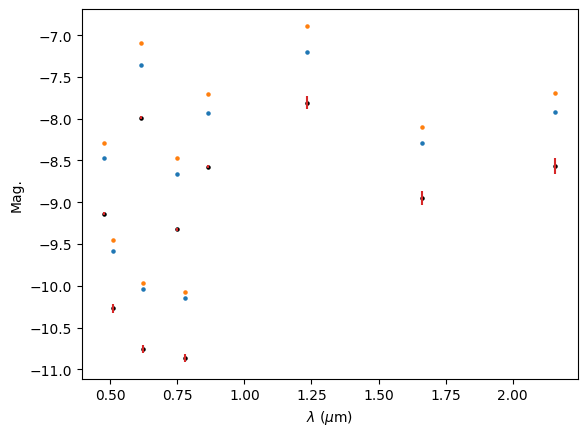

In [11]:
fig, ax = plt.subplots()

for wavelength, mag, err in zip(WAVE, photcomp, emags):
    # ax.scatter(wavelength/1E+4, mag, c='k', s=5)
    # ax.errorbar(wavelength/1E+4, mag, yerr=err, ls='',marker=',',c='C3',zorder=1)
    ax.scatter(wavelength/1E+4, mag, s=5, c='k',zorder=0)
    ax.errorbar(wavelength/1E+4, mag, yerr=err, c='C3',zorder=1)

ax.scatter(WAVE/1E+4, phot_p, s=5, c='C0', zorder=1)
ax.scatter(WAVE/1E+4, phot_s, s=5, c='C1', zorder=1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)')
ax.set_ylabel(r'Mag.')

In [12]:
# output composite spectrum to csv
with open(f'synth_speccomp.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['wave', 'flux', 'eflux'])

    for row in zip(data_p['spec']['obs_wave'], speccomp+noise, noise):
        # print(row)
        csv_out.writerow(row)
print(f'synthetic composite spectrum output to /etc/demo_smes/synth_speccomp.csv')

synthetic composite spectrum output to /etc/demo_smes/synth_speccomp.csv


In [13]:
# output composite photometry to csv
with open(f'synth_photcomp.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['band', 'mag', 'emag'])

    for row in zip(WAVE_d.keys(), photcomp, emags):
        # print(row)
        csv_out.writerow(row)
print(f'synthetic composite photometry output to /etc/demo_smes/synth_photcomp.csv')

synthetic composite photometry output to /etc/demo_smes/synth_photcomp.csv


In [14]:
Table.read('synth_speccomp.csv')

wave,flux,eflux
float64,float64,float64
5102.44019769569,1.016109047051562,0.06325772016628864
5102.457205829683,1.0010545014014036,0.05718400270359742
5102.474214020369,1.0040487524091746,0.05976054694391419
5102.4912222677485,1.0140738909117821,0.06538119471896288
5102.508230571823,1.0106630897121467,0.06371865299112676
5102.525238932592,0.9864781386909562,0.05104998893776795
5102.542247350055,1.005985312954276,0.05963296428155311
5102.559255824213,0.9995012541396912,0.05472799076318018
5102.576264355066,1.003679332579287,0.05494236118540989


In [15]:
Table.read('synth_photcomp.csv')

band,mag,emag
str10,float64,float64
GaiaDR3_G,-10.759547923831544,0.05000091916311386
GaiaDR3_BP,-10.271529927812185,0.05004763662644478
GaiaDR3_RP,-10.862020203612362,0.050012894094444295
2MASS_J,-7.807358797866772,0.07733692547677395
2MASS_H,-8.951700121790541,0.08683893326204858
2MASS_Ks,-8.56668035340865,0.10121264701645077
PS_g,-9.136529592031822,0.020829461749839007
PS_r,-7.987081819600262,0.02065512096136038
PS_i,-9.324977148383503,0.020870045165005097


In [16]:
from runUTPbinary_synth import getdata as getdata_synth
test_data = getdata_synth()
test_data

{'spec': {'obs_wave': <Column name='wave' dtype='float64' length=14128>
    5102.44019769569
   5102.457205829683
   5102.474214020369
  5102.4912222677485
   5102.508230571823
   5102.525238932592
   5102.542247350055
   5102.559255824213
   5102.576264355066
   5102.593272942613
   5102.610281586857
   5102.627290287795
                 ...
  5348.2825125455975
   5348.300340153973
   5348.318167821773
   5348.335995548999
   5348.353823335651
   5348.371651181729
   5348.389479087234
   5348.407307052164
   5348.425135076521
   5348.442963160304
   5348.460791303515,
  'obs_flux': <Column name='flux' dtype='float64' length=14128>
   1.016109047051562
  1.0010545014014036
  1.0040487524091746
  1.0140738909117821
  1.0106630897121467
  0.9864781386909562
   1.005985312954276
  0.9995012541396912
   1.003679332579287
     1.0118597555581
  1.0124444497886993
   1.026063531467591
                 ...
   1.132313997335042
  1.1412011263139168
  1.1687926096707726
  1.1601435287456174
  

(5200.0, 5215.0)

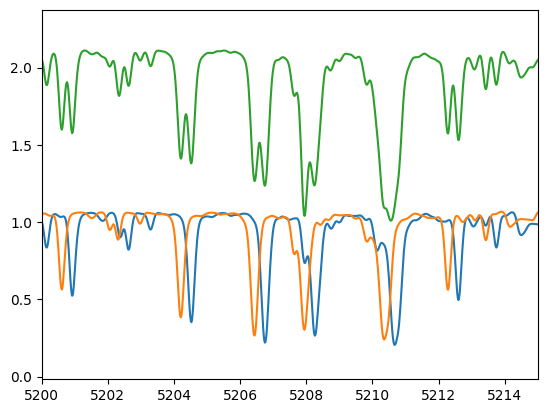

In [17]:
# relearning how interpolation works:
plt.plot(data_p['spec']['obs_wave'], flux2_interp)
plt.plot(data_p['spec']['obs_wave'], data_p['spec']['obs_flux'])
plt.plot(data_p['spec']['obs_wave'], flux2_interp+data_p['spec']['obs_flux'])
plt.xlim(5200,5215)